# Wavetable Synthesis and Envelopes
## George Tzanetakis 


Pitched musical sounds have a period component that results in the perception of a well-defined pitch. When viewed as a time-domain waveform it is clear that for most instrument sounds there is a short non-periodic attack portion of the sound that is critical for the perceived identity of the resulting sound. 

As memory costs when down in the 1980s, it became possible to store samples of musical sounds rather than generating them with analog circuitry. In order to save memory it is common to store just one loop instance of the periodic part of the sound and repeat it during playback as needed. The array storing the samples is called the **wavetable**. The attack portion can also be stored as an array digital samples. The resulting synthesizers are called samplers and were able to immitate acoustical musical instruments sounds much more accurately than analog synthesizers. 

The term **wavetable synthesis** is more general and refers to the use of stored arrays of samples as part of a synthesis architecture and not just using them directly for playback. 

Let's first take a look at how we can use this approach for sinusoidal playback. 

In [1]:
import numpy as np
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt


def plot(data_list): 
    fig, ax = plt.subplots(figsize=(4,3))
    for data in data_list: 
        plt.plot(data)

In [2]:
# generate a discrete time sine signal with a specified amplitude, frequency, duration, and 
# phase 
def sinusoid(freq=440.0, dur=1.0, srate=44100.0, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

srate = 48000
data = sinusoid(freq=261.63, dur=2, srate=srate)
ipd.Audio(data, rate=srate)

Using this approach we are able to create sinusoidal sounds with user-specified frequency and duration which means we can create simple melodies and potentially polyphony by appropriately summing the generated audio signals. 

However, there are several limitations of this approach. Every audio sample is computed by calling the np.sin() function. The longer the duration of the generated sound, the more calls need to be made. We know that the **sin** function is periodic so it should be possible to only compute the values of the function for one period and then reuse them. 
Another limitation is that we can only generate sinusoidal audio signals - ideally we would like a more general approach that can accomodate the generation of any periodic signal. We also would like to change (modulate) dynamically the frequency of the oscillator to generate more interesting signals. For example, analog synthesizers frequently provide a Low Frequency Oscillator (LFO) that can be use to modulate the frequency of a Voltage Control Oscillator (VCO). LFOs change at slow rates to provide effects like vibrato. 

Let's try to modify the code above by adding a LFO signal. 

In [3]:
def sinusoid_lfo_attempt1(freq = 440.0, dur=1.0, srate = 48000, amp=1.0, 
                          mode = 'lfo'):
        t = np.arange(0,int(srate*dur))
        lfo = np.sin(2 * np.pi * 2/srate * t)
        if mode == 'lfo': 
            f = freq + 100 * lfo  # f is an array 
        elif mode == 'constant': 
            f = freq  # f is a single value 
        else: 
            f = freq
            print('Unsupported mode')
        data = amp * np.sin(2*np.pi*f/srate * t)       
        return data
    
data = sinusoid_lfo_attempt1(freq=261.63, dur=3.0, mode='lfo')   # C4
ipd.Audio(data, rate=srate)

The resulting sound is interesting but not what we would expect for an LFO-modulated sinusoid. Instead of a a vibrato around a fixed frequency it keeps increasing in frequency. 
This has to do with the difference between instanteneous frequency and phase and frequency of the sinusoid. For those of you interested in the more signal processing aspects you can read more about this here: https://en.wikipedia.org/wiki/Instantaneous_phase_and_frequency

To fix this problem we need to calculate how much to increase the phase at every sample. To make this process more explicit we will not take advantage of the vector operation of numpy and instead have an explicit loop. This would also be how one would code this in a lower level language like C or Assembly. 

In [4]:
def sinusoid_lfo_loop1(freq = 440.0, dur = 1.0, srate = 48000, amp=1.0, 
                      apply_lfo=True): 
    # allocate arrays 
    indices = np.arange(0, int(srate*dur))
    f = np.zeros(indices.shape)
    p = np.zeros(indices.shape)
    lfo = np.zeros(indices.shape)
    data = np.zeros(indices.shape)
    
    # loop version 
    for i in indices: 
        lfo[i] = np.sin(2 * np.pi * 2 / srate *i)
        if apply_lfo: 
            f[i] = freq + 100.0 * lfo[i]
        else: 
            f[i] = freq   
        if (i > 0): 
            p[i] = (p[i-1] + f[i]/srate)  
        data[i] = amp * np.sin(2 * np.pi * p[i])
    return data 

data = sinusoid_lfo_loop1(freq=261.63, dur = 4.0, apply_lfo=True)
ipd.Audio(data, rate=srate)



Notice that the phase keeps increasing. This is not ideal because over longer time periods it could be come really big and cause numerical problems. Because the sinusoidal signal is periodic we can reset the phase every period using a mod operation. The resulting signal sounds the same but observe how the plot changes. 

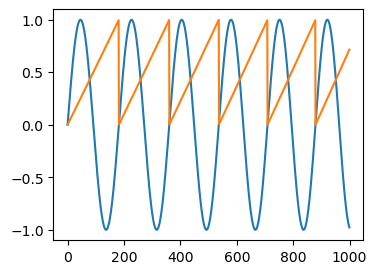

In [5]:
def sinusoid_lfo_loop2(freq = 440.0, dur = 1.0, srate = 48000, amp=1.0, 
                      apply_lfo=True): 
    # allocate arrays 
    indices = np.arange(0, int(srate*dur))
    f = np.zeros(indices.shape)
    p = np.zeros(indices.shape)
    lfo = np.zeros(indices.shape)
    data = np.zeros(indices.shape)
    
    # loop version 
    for i in indices: 
        lfo[i] = np.sin(2 * np.pi * 2 / srate *i)
        if apply_lfo: 
            f[i] = freq + 100.0 * lfo[i]
        else: 
            f[i] = freq   
        if (i > 0): 
            # here is the mod operation - the resulting phase increment 
            # has a saw tooh patten 
            p[i] = (p[i-1] + f[i]/srate) % 1.0 
        data[i] = amp * np.sin(2 * np.pi * p[i])
    plot([data[0:1000], p[0:1000]])
    return data 

data = sinusoid_lfo_loop2(freq=261.63, dur = 4.0, apply_lfo=True)
ipd.Audio(data, rate=srate)



Now that we better understand the phase increment, we can recreate the 
above functions in vector form. Notice the that the np.cumsum keeps increasing. We could write a version that does the mod operation. This is left as an activity for the reader. 

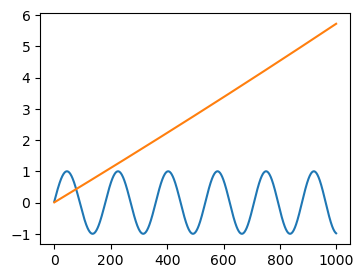

In [21]:
def sinusoid_lfo_vectorized(freq = 440.0, dur = 1.0, srate = 48000, amp=1.0, apply_lfo=True): 
    indices = np.arange(0, int(srate*dur))
    f = np.zeros(indices.shape)
    p = np.zeros(indices.shape)
    lfo = np.zeros(indices.shape)
    data = np.zeros(indices.shape)
    
    lfo = np.sin(2 * np.pi * 2 / srate *indices)
    if apply_lfo: 
        f = freq + 100.0 * lfo
    else: 
        f = np.repeat(freq,indices.shape[0])
    p = np.cumsum(f/srate)
    data = amp * np.sin(2 * np.pi * p)
    plot([data[0:1000], p[0:1000]])
    return data 

data = sinusoid_lfo_vectorized(freq=261.63, dur = 2.0, apply_lfo=True)
ipd.Audio(data, rate=srate)


Now that we have dealt with the issue of instantaneous frequency and phase let's look at reducing the memory footprint of the calculation. We know that the underlying sinusoidal signal is periodic. The idea behind a wavetable is to calculate and store the samples of one period of the waveform and then reuse them as needed. 

Let's try to see if we can create a sound by only computing one period of the underlying periodic function and then repeating it. Notice that I have "cooked" the numbers so that the resulting wavetable size is an integer number of samples. This is typically not the case and we will look at how to deal with it later in this notebook. 


Wavetable size 100.0


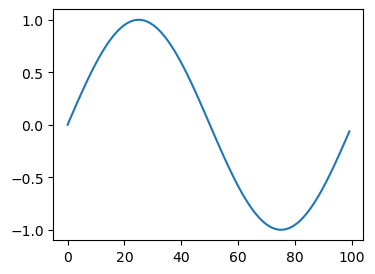

In [7]:
srate = 16000 
freq = 160 
wavetable_size = srate / freq
print('Wavetable size', wavetable_size)

t = np.arange(0, wavetable_size)
wavetable = np.sin(2 * np.pi * freq / srate * t)
plot([wavetable])

# repeat/tile the wavetable 320 times to create the data array 
data = np.tile(wavetable, 320)
ipd.Audio(data, rate=srate)

Let's see if we can make this approach a little bit more general. 
The wavetable is created for a specific frequency and sample rate and then reused to a generate a sound of user-specified duration. This saves both computation (the np.sin calls are only done once at the start when **create_wavetable** is called) and memory. Notice that we still allocate the fully array of samples (data) for playback but in real-time scenarios we would generate the samples in small buffers as we will see later. 

One small thing to notice is that the true period for the wavetable is 
srate / frequency which is 183.46 samples. This is rounded up to 184 which means that the wavetable contains a little bit more than one period. This can cause issues when it is repeated. 

There are still some limitations with this approach. The wavetable needs to be recreated any time we want to play a sound of different frequency and it also only supports playback of sinusoids. We will address these limitations below. 


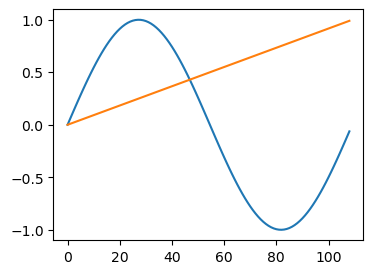

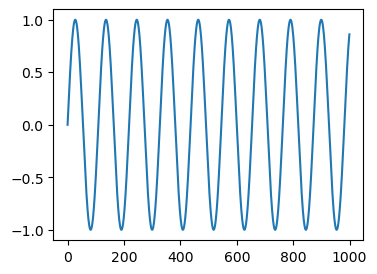

In [8]:
def create_wavetable(freq, srate):
    # the wavetable length will be the period corresponding
    # to the frequency at the specified sample rate
    wavetable_length = int(srate / freq) 
    wavetable = np.zeros(wavetable_length)
    f = np.zeros(wavetable_length)
    p = np.zeros(wavetable_length)
    for i in np.arange(0,wavetable_length): 
        f[i] = freq
        if (i>0): 
            p[i] = (p[i-1]+f[i]/srate) % 1.0 
        wavetable[i] = np.sin(2 * np.pi * p[i])

    plot([wavetable[0:wavetable_length], p[0:wavetable_length]])
    return wavetable 


def sinusoid_wavetable(freq = 440.0, dur = 1.0, srate = 48000, 
                       amp=1.0):    
    wavetable = create_wavetable(freq, srate)
    indices = np.arange(0, int(srate*dur))
    data = np.zeros(indices.shape)

    for i in indices: 
        wavetable_index = i % wavetable.shape[0] 
        # read the samples from the wavetable 
        data[i] = wavetable[wavetable_index] 
    fig, ax = plt.subplots(figsize=(4,3))
    plt.plot(data[0:1000])
    return data 

data = sinusoid_wavetable(freq=440, dur = 2.0)
ipd.Audio(data, rate=srate)



We can generalize the notion of a wavetable to compute any function by storing samples of that function in memory. We can define different function for different types of periodic functions that are common in synthesizers such as sawtooh, square, and triangle waveforms. We will also like to only have one wavetable and be able to generate any frequency from it. This can be done by computing different phase increments depending on the frequency rather than reading from the wavetable one value at a time. Another way to view this is as reading from the wave table at different sampling rates. 

In order, to return a value for non-integer phase increments some form of interpolation is needed. The **wavetable_lookup** function serves this purposes and supports three different approaches. 

In [9]:
def sawtooth(x):
    return (x - np.pi)/np.pi

def square(x):
    return np.sign(sawtooth(x))

def triangle(x):
    return 1 - 2 * np.abs(sawtooth(x))

# notice that the wavetable just stores 
# values of the function 
def create_wavetable(length, fn):
    L = length+1 # add one sample to wavetable to allow edge interpolation
    t = np.linspace(0, 1.0 , L)
    wavetable = fn(2 * np.pi * t)
    return wavetable
    
# wavetable look (truncate and round only use one sample), 
# interpolate uses two samples and is more accurate 
def wavetable_lookup(phase_index, wavetable, mode): 
    if (mode == 'truncate'): 
        return wavetable[int(phase_index)]
    elif (mode == 'round'): 
        return wavetable[round(phase_index)]
    elif (mode == 'interpolate'): 
        x  = phase_index
        x0 = int(phase_index)
        x1 = x0+1
        y0 = wavetable[x0]
        y1 = wavetable[x1]
        return y0 * (x1-x) + y1 * (x - x0)
    else:
        return 0.0 
    

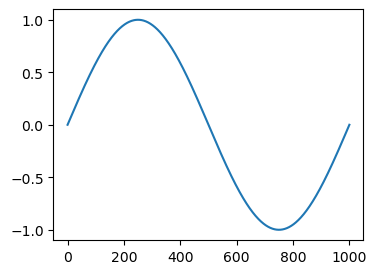

In [10]:
table_length = 1000
phase_index = 0 
freq = 220 
phase_increment = (table_length * freq) / srate 
data = np.zeros(srate)

wavetable = create_wavetable(table_length, np.sin)
plot([wavetable])
for t in np.arange(0,srate): 
    phase_index = (phase_index + phase_increment) % table_length
    data[t] = wavetable_lookup(phase_index, wavetable, mode='round')
ipd.Audio(data, rate=srate)

Let's try a different waveform 

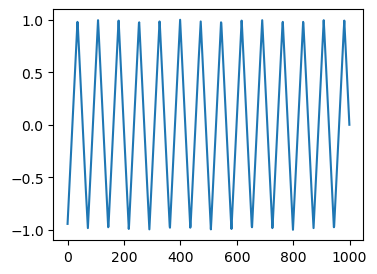

In [11]:
wavetable = create_wavetable(table_length, triangle)

for t in np.arange(0,srate): 
    phase_index = (phase_index + phase_increment) % table_length
    data[t] = wavetable_lookup(phase_index, wavetable, mode='round')

plot([data[0:1000]])   
ipd.Audio(data, rate=srate)

If we make the wavetable too small then we start hearing artifacts because of the quantization and interpolation. 

In [12]:
table_length = 20
phase_index = 0 
freq = 220 
phase_increment = (table_length * freq) / srate 
data = np.zeros(srate)

wavetable = create_wavetable(table_length, np.sin)
for t in np.arange(0,srate): 
    phase_index = (phase_index + phase_increment) % table_length
    data[t] = wavetable_lookup(phase_index, wavetable, mode='round')
ipd.Audio(data, rate=srate)

One can analyze the error of different types of interpolation 
when using table lookup for sinusoidal singnals: 

Moore FR. Table lookup noise for sinusoidal digital oscillators. Computer Music Journal. 1977 Apr 1:26-9.
https://www.jstor.org/stable/pdf/23320138.pdf

As well as generalize to more than sinusoids: 
Dannenberg RB. Interpolation error in waveform table lookup. International Computer Music Conference, 1998 

https://kilthub.cmu.edu/articles/Interpolation_Error_in_Waveform_Table_Lookup/6606596/files/12097115.pdf 



It is straightforward to extend the code above in various ways to enable more possibilities. Here are some examples: 

1. The sawtooth signals that correspond to the phase increments are sometimes called phasors. One can support polyphony using the same wavetable by using multiple phasors to generate different frequencies. One can think of the wavetable as a a circular array of values sometimes called a ring buffer that is being read at different sampling rates using interpolation. It is also possible to have multiple wavetables for supporting polyphony. The multiple phasors approach supports polyphony of the same underlying waveform but having multiple wavetables supports polyphony with potentially different oscillators (multi-timbrality) 

2. To provide more flexibility the wavetable oscillator(s) can take as argument time-varying envelopes for amplitude, frequency, and phase. For example one could add Attack, Decay, Sustain, Release envelopes for the amplitude. This generalizes oscillators to the concept of unit-generators that are fundamental building blocks in most computer music languages and programming environments and enables various types of interesting modulations. 

3. In languages that support object-oriented programming one can write the oscillators as objects and keep their state (for example phase-increment) as part of the object. This also allows the creation of more complex architectures like patches of unit generators. 



ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


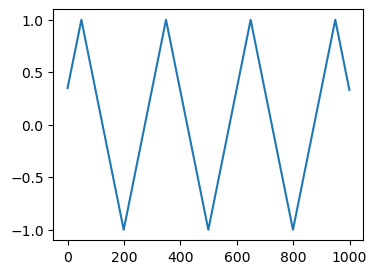

In [24]:
import sys
import pyaudio
import numpy as np



def create_wavetable(length, fn):
    L = length+1 # add one sample to wavetable to allow edge interpolation
    t = np.linspace(0, 1.0 , L)
    wavetable = fn(2 * np.pi * t)
    return wavetable

# wavetable look (truncate and round only use one sample), 
# interpolate uses two samples and is more accurate 
def wavetable_lookup(phase_index, wavetable, mode): 
    if (mode == 'truncate'): 
        return wavetable[int(phase_index)]
    elif (mode == 'round'): 
        return wavetable[round(phase_index)]
    elif (mode == 'interpolate'): 
        x  = phase_index
        x0 = int(phase_index)
        x1 = x0+1
        y0 = wavetable[x0]
        y1 = wavetable[x1]
        return y0 * (x1-x) + y1 * (x - x0)
    else:
        return 0.0 

def oscillator(freq, wavetable, nsamples, phase_index): 
    table_length = wavetable.shape[0]
    for t in np.arange(nsamples): 
        phase_increment = (table_length * freq) / srate 
        phase_index = (phase_index + phase_increment) % table_length
        sample = wavetable_lookup(phase_index, wavetable, mode='interpolate')
        data[t] = sample
    return (phase_index, data)
        
table_length = 1000
wavetable = create_wavetable(table_length, np.sin)
srate = 48000 
freq = 160
phase_index = 0 

CHUNK = 1024
# Instantiate PyAudio and initialize PortAudio system resources (1)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True)

data = np.zeros(CHUNK)
# Generate small buffers of CHUNK size and play using blocking write calls 
for i in np.arange(0, 100):        
    (phase_index, data) = oscillator(160.0, wavetable, CHUNK, phase_index)
    stream.write(data.astype(np.float32).tobytes())
    
# Play a different oscillator (triangle)
wavetable = create_wavetable(table_lengastypeth, triangle) 
for i in np.arange(0, 100):        
    (phase_index, data) = oscillator(160.0, wavetable,CHUNK,phase_index) 
    if (i == 0):
        fig, ax = plt.subplots(figsize=(4,3))
        plt.plot(data[0:1000])
    stream.write(data.astype(np.float32).tobytes())
    
stream.close()
p.terminate()

Let's use an object for the wavetable oscillator. That way we can 
initilize the state of the oscillator with things like the wavetable and the frequency. 


In [14]:
class WavetableOscillator:
    
    def create_wavetable(self, length, fn): 
        L = length+1 # add one sample to wavetable to allow edge interpolation
        t = np.linspace(0, 1.0 , L)
        wavetable = fn(2 * np.pi * t)
        return wavetable

    def __init__(self, nsamples=1024):
        self.phase_index = 0.0 
        table_length = 1000 
        self.wavetable = self.create_wavetable(table_length, np.sin)
        self.table_length = table_length
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.freq = 220.0
        self.srate = 48000 
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        
    def process(self): 
        for t in np.arange(self.nsamples): 
            phase_increment = (self.table_length * self.freq) / self.srate 
            self.phase_index = (self.phase_index + phase_increment) % table_length
            sample = wavetable_lookup(self.phase_index, wavetable, mode='interpolate')
            data[t] = sample
            # print('phase index', self.phase_index)
        return data 

In [15]:
CHUNK = 1024
# Instantiate PyAudio and initialize PortAudio system resources (1)
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True)
        
        
osc1 = WavetableOscillator(nsamples=CHUNK)
for i in np.arange(0, 100): 
    data = osc1.process()
    stream.write(data.astype(np.float32).tobytes())

stream.close()
p.terminate()

ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


Using the object-oriented oscillator, we can also show the callback style of interacting with the audio device. In this approach, we proviee a callback function to generate the samples as needed and this function is called by PyAudio whenever samples are needed to maintain real-time audio playback. 


In [16]:
import time 
osc1 = WavetableOscillator(nsamples=64)

def callback(in_data, frame_count, time_info, status):
    osc1.set_nsamples(frame_count)
    data = osc1.process()
    return (data.astype(np.float32).tobytes(), pyaudio.paContinue)

 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                stream_callback=callback)

time.sleep(2.0)
print('Playback done')
stream.close()
p.terminate()


ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


Playback done


We extend our approach with adding amplitude modulation and envelopes by appropriately defining an object that handles the generation of the envelope signal. Here is an example of a simple attack ramp. It is straighforward to extend/generalize it to a ADSR envelope. 

In [17]:

class AttackRamp: 
    def __init__(self, nsamples=1024):
        self.duration = 48000 
        self.nsamples = nsamples 
        self.data = np.zeros(self.nsamples)
        self.amp = 0.0 
        self.noteon = False 
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        
    def note_on(self): 
        self.noteon = True 
        
    def process(self): 
        if (self.noteon): 
             amp_increment = 1.0 / self.duration 
        else: 
            amp_increment = 0.0 
        
        for t in np.arange(self.nsamples): 
            self.amp = self.amp + amp_increment 
            if self.amp > 1.0: 
                self.amp = 1.0 
                self.noteon = False 
            self.data[t] = self.amp 

        return self.data
    
class WavetableOscillator:
    
    def create_wavetable(self, length, fn): 
        L = length+1 # add one sample to wavetable to allow edge interpolation
        t = np.linspace(0, 1.0 , L)
        wavetable = fn(2 * np.pi * t)
        return wavetable

    def __init__(self, amp_modulator, nsamples=1024):
        self.phase_index = 0.0 
        table_length = 1000 
        self.wavetable = self.create_wavetable(table_length, np.sin)
        self.table_length = table_length
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.freq = 220.0
        self.srate = 48000 
        self.amp_modulator = amp_modulator 
        self.noteon = False
        
    def note_on(self): 
        print('NOTON')
        self.noteon = True 
        self.amp_modulator.note_on()
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.amp_modulator.set_nsamples(self.nsamples)
        
    def process(self): 
        amplitudes = self.amp_modulator.process()
        for t in np.arange(self.nsamples): 
            phase_increment = (self.table_length * self.freq) / self.srate 
            self.phase_index = (self.phase_index + phase_increment) % table_length
            sample = wavetable_lookup(self.phase_index, wavetable, mode='interpolate')
            self.data[t] = amplitudes[t] * sample
        return self.data   

NOTON


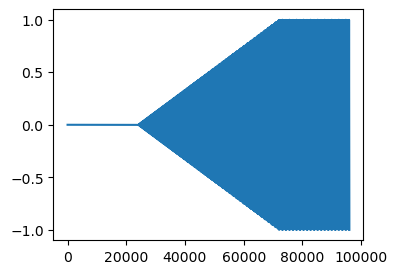

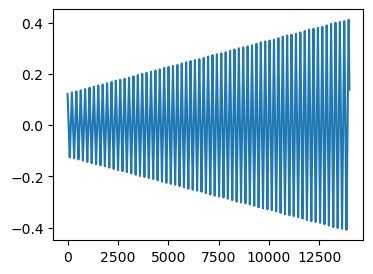

In [18]:

duration_samples = 48000 * 2 
chunk_size = 64
iterations = int(duration_samples / chunk_size) 

amp_env = AttackRamp(chunk_size) 
osc1 = WavetableOscillator(amp_env, chunk_size)
audio_data = np.zeros(duration_samples)
audio_buffers = []
for i in np.arange(0,iterations): 
    data = osc1.process() 
    
    # trigger a note on event at a particular time 
    if (i == iterations / 4): 
        osc1.note_on()
        
        
    nsamples = data.shape[0]
    for t in np.arange(0,nsamples): 
        audio_data[i * nsamples + t] = data[t]
plot([audio_data])
plot([audio_data[30000:44000]])
ipd.Audio(audio_data, rate=48000)



In [19]:
import time 

duration_samples = 48000 * 2 
chunk_size = 64

amp_env = AttackRamp(chunk_size) 
osc1 = WavetableOscillator(amp_env, chunk_size)


def callback(in_data, frame_count, time_info, status):
    osc1.set_nsamples(frame_count)
    data = osc1.process()
    return (data.astype(np.float32).tobytes(), pyaudio.paContinue)

 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                stream_callback=callback)

time.sleep(2.0)
print('Playback done')
stream.close()
p.terminate()


ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


Playback done


The AttackRamp is a simplified version of the more common Attack, Decay, Sustain, Release envelope and only partially handles NoteOn events. It is relatively straightforward to write an ADSR amplitude envelope that correctly supports NoteOn, NoteOff events and has all four stages. The ADSR envelope generator should always produce samples (zeros when there is no envelope) and have the number of samples generated be adjustable. 


There is a lot more work that could go into our little synthesizer simulation. More flexible representations of time (samples, seconds, beats with time-varying tempo) are possible and can be used for triggering events such as note on and note off. More flexible representations of frequency (MIDI note number, music notation string, frequency in Hz, frequency in cents, scale number connected to scale specified by frequencies to support multiple tuning systems). 
In addition to amplitude modulation, we can add frequency and phase modulation. 

A proper object oriented hierarchy could be made with abstract classes for oscillators, mutators etc with specific instances for particular waveforms. Both single timbre polyphony and multi-timbrality can be added as well as 
operators on the oscillators such as adders and multipliers. 


Using just sinusoidal oscillators and amplitude envelopes it is possible to create some pretty cool sounds. 
Check out this notebook for how to recreate the iconic THX sound logo using Python. After the material covered in this notebook You should be able to understand the code behind the THX logo. A good exercise it to rewrite the code to use wavetable oscillators instead of direct computation and create a real-time version. 

https://colab.research.google.com/github/stevetjoa/musicinformationretrieval.com/blob/gh-pages/thx_logo_theme.ipynb


### TO DO 

The following items are interesting things to work on either on your or I might add them at some point to the notebook. 

1. Make full ADSR envelope 
2. Include frequency sweep and lfo frequency modulation using the wavetable oscillators 
3. Add MIDI input using Mido 
4. Add real-time visualizations of the waveforms using Boreal 
5. Include some historical information about Max Mathews and the IBM 704 (especially about memory and tape capacity) 




